In [1]:
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import LabelEncoder
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, BatchNormalization, Dropout, Flatten, Dense
from keras.optimizers import Adam
import keras
import sklearn
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential

import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import itertools
from datetime import datetime

Using TensorFlow backend.


Mounting Google drive to persist data

In [2]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir(r'/content/drive/My Drive/AI Project Work')
ROOT_PATH = os.getcwd ()

/Users/kunjpatel/opt/anaconda3/lib/python3.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")


KeyError: 'CLOUDSDK_CONFIG'

Transformations to the input MFCC data

In [0]:
def scale_data (x):
    scaler = StandardScaler().fit (x)
    # scale everything
    scaled = scaler.transform(x)
    return scaled


def getEncodedLabel (inputList):
    encoder = LabelEncoder()
    encoder.fit (inputList)
    classList = encoder.classes_
    encodedList = encoder.transform(inputList)
    return encodedList, classList

Read and Transform the input data, Split input to train and with-held test data

In [0]:
mapDatabyName = {}
mapEmotionbyName = {}
label_age = []
label_emotion = []

rawdata = pd.read_csv('MFCC_Emotion.csv', delimiter=',')

X = rawdata.iloc[:, :-1]
label = rawdata.iloc[:, -1]

encoder = LabelEncoder()
encoder.fit(label)
classList = np.unique(label)
num_emotion = len(classList)

print('num emotion: {}'.format(len (classList)))
print('emotions: {}'.format(classList))

y = encoder.transform (label)

# train/test split
X_train, X_test, Y_train, Y_test = train_test_split (X, y, test_size=0.2, shuffle=True, random_state=123)

# reshape to (~, 43, 1)
X_train = X_train.values.reshape(-1, 43, 1)
X_test = X_test.values.reshape(-1, 43, 1)

num emotion: 7
emotions: ['Angry' 'Disgust' 'Fear' 'Happy' 'Neutral' 'PS' 'SAD']


Building Conv Neural Network

In [0]:
"""Build CNN"""
def buildNet(lr=0.001, kernel_size=3, strides=2):
    conv1 = Conv1D (filters=128, kernel_size=kernel_size,
                                    strides=strides, padding='same',
                                    activation='sigmoid',
                                    name='conv1')#, input_shape=(43,1))
    bn1 = BatchNormalization (name='bn1')
    # drop1 = Dropout (rate=0.4, name='drop1')

    conv2 = Conv1D (filters=256, kernel_size=kernel_size,
                                    strides=strides, padding='same',
                                    activation='sigmoid',
                                    name='conv2')
    bn2 = BatchNormalization (name='bn2')
    # drop2 = Dropout (rate=0.4, name='drop2')

    flat = Flatten (name='flatten')
    fc = Dense (units=128, activation='relu', name='fc2')
    # drop3 = Dropout (rate=0.4, name='drop3')
    
    output = Dense (units=num_emotion, activation='softmax')

    model = Sequential([conv1, bn1, conv2, bn2, flat, fc, output])
    adam = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [0]:
""" loss plot """
def plot_loss(epochs, loss, val_loss, class_category = None):
    plt.plot(epochs, loss, '--', label= 'Training Loss',lw =2)
    plt.plot(epochs, val_loss, '-', label= 'Validation Loss',lw =2)
    plt.title('training and validation loss - {}'.format(class_category), fontsize=18)
    plt.xlabel('Epochs', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.legend(fontsize=12)
    plt.tight_layout ()


""" accuracy plot """
def plot_accuracy(epochs, acc, val_acc, class_category = None):
    plt.plot (epochs, acc, '--', label='Training Accuracy', lw=2)
    plt.plot (epochs, val_acc, '-', label='Validation Accuracy', lw=2)
    plt.title ('training and validation accuracy - {}'.format(class_category), fontsize=18)
    plt.xlabel ('Epochs', fontsize=14)
    plt.ylabel ('Accuracy', fontsize=14)
    plt.legend (fontsize=12)
    plt.tight_layout ()
    

""" confusion matrix plot """
def plot_confusion_matrix(cm, classes,normalize=False,
                         title='Confusion matrix',
                      cmap=plt.cm.PuBu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')    
        print(cm)    
    plt.title(title, fontsize = 16)    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)    
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.clim(0, 1)
    plt.ylabel('True label', fontsize =12)
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.tight_layout ()

In [0]:
model = KerasClassifier(build_fn=buildNet, verbose=0)

batch_size = [2000, 5000]
epochs = [20, 50, 100]
learning_rates = [0.001, 0.005, 0.0001]
kernel_size = [3, 5]
strides = [1, 2]

param_grid = {'batch_size':batch_size, 'epochs':epochs, 'lr':learning_rates, 'kernel_size':kernel_size, 'strides':strides}
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=3, cv=3, scoring='accuracy', verbose=10)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 tasks      | elapsed: 113.0min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=3)]: Done   7 tasks      | elapsed: 279.4min
[Parallel(n_jobs=3)]: Done   9 out of  12 | elapsed: 283.5min remaining: 94.5min
[Parallel(n_jobs=3)]: Done  12 out of  12 | elapsed: 338.6min finished


Best: 0.749310 using {'batch_size': 5000, 'epochs': 100, 'lr': 0.001, 'strides': 2}
0.720672 (0.007051) with: {'batch_size': 5000, 'epochs': 100, 'lr': 0.001, 'strides': 1}
0.749310 (0.001333) with: {'batch_size': 5000, 'epochs': 100, 'lr': 0.001, 'strides': 2}
0.717771 (0.015492) with: {'batch_size': 5000, 'epochs': 100, 'lr': 0.0001, 'strides': 1}
0.706481 (0.001559) with: {'batch_size': 5000, 'epochs': 100, 'lr': 0.0001, 'strides': 2}
(174341,)
Normalized confusion matrix


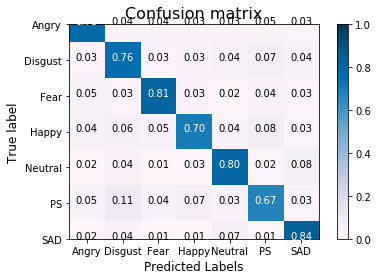

In [0]:
grid_result = grid.fit(X_train, Y_train)

now = datetime.now()

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

with open('results'+now.strftime("%m-%d-%Y-%H:%M:%S")+'.csv', 'w') as txtfile:
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_), file=txtfile)
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param), file=txtfile)

# get prediction on hold-out test data
best_model = grid.best_estimator_
Y_test_predict = best_model.predict(X_test)

# calculate/plot confusion matrix -
print("---Test Confusion matrix---")
confusion_matrix = metrics.confusion_matrix(Y_test, Y_test_predict)
plt.figure()
plot_confusion_matrix(confusion_matrix, classes=classList,normalize=True)
plt.savefig(os.path.join( 'rts/confusionmat_MFCC_{}'.format(now.strftime("%m-%d-%Y-%H:%M:%S"))+ '.pdf'), bbox_inches="tight")

In [0]:
best_model = mod

In [0]:
# Precision and Recall Metrics

Y_train_predicted = best_model.predict(X_train)
train_prec_recall = metrics.classification_report(Y_train, Y_train_predicted)
print("-------Train Precision Recall-------\n" + train_prec_recall)

Y_test_predicted = best_model.predict(X_test)
test_prec_recall = metrics.classification_report(Y_test, Y_test_predicted)
print("-------Test Precision Recall-------\n" + test_prec_recall)

-------Train Precision Recall-------
              precision    recall  f1-score   support

           0       0.86      0.86      0.86     89387
           1       0.82      0.84      0.83    118680
           2       0.85      0.88      0.87     80795
           3       0.85      0.78      0.81     95657
           4       0.83      0.86      0.84     99428
           5       0.80      0.77      0.78     97178
           6       0.87      0.89      0.88    116237

    accuracy                           0.84    697362
   macro avg       0.84      0.84      0.84    697362
weighted avg       0.84      0.84      0.84    697362

-------Test Precision Recall-------
              precision    recall  f1-score   support

           0       0.78      0.78      0.78     22007
           1       0.74      0.76      0.75     29756
           2       0.77      0.81      0.79     20112
           3       0.76      0.70      0.73     23756
           4       0.77      0.80      0.78     24972
     

In [0]:
# save the model

from sklearn.externals import joblib
joblib.dump(grid.best_estimator_, 'model-'+now.strftime("%m-%d-%Y-%H:%M:%S")+'.pkl')

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['model-12-03-2019-02:39:25.pkl']

************Checking with test set************
-------Loading saved model file: model-12-03-2019-02_39_25.pkl-------


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)














Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Accuracy: 0.7647828106985735
Confusion Matrix:
 [[17099   906   958   709   733   993   609]
 [  760 22530   843  1031  1231  2175  1186]
 [  919   626 16204   676   362   787   538]
 [  959  1438  1137 16633   917  2017   655]
 [  557  1060   367   660 19863   587  1878]
 [ 1097  2600  1050  1813   788 16374   649]
 [  444  1113   423   359  1968   430 24630]]
Normalized confusion matrix


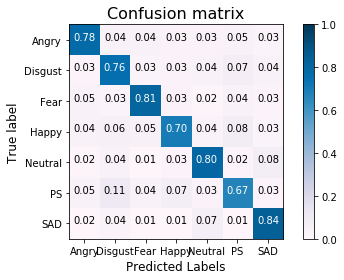

In [0]:
# Load the saved model

model_file = 'model-12-03-2019-02_39_25.pkl'

print("************Checking with test set************")
from sklearn.externals import joblib

print("-------Loading saved model file: "+model_file+"-------")
mod = joblib.load(model_file)
y_pred = mod.predict(X_test)
print("Accuracy:",metrics.accuracy_score(Y_test, y_pred))
conf_matrix=metrics.confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n",conf_matrix)
plt.figure()
plot_confusion_matrix(conf_matrix, classes=classList,normalize=True)